# CEIA - 16Co2024 - Visión por Computadora 1 - TP2

**Myrna L. Degano (a1618)**  
**Gustavo J. Rivas (a1620)** 

## Objetivo

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. 
El video a procesar será: “focus_video.mov”.

In [1770]:
#!pip install numpy
#!pip install opencv-python
#!pip install matplotlib

In [1772]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## 1.

Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper ["Image Sharpness Measure for Blurred Images in Frequency Domain“](./papers/ImageSharpnessMeasureforBlurredImagesinFrequency.pdf) y realizar tres experimentos:

1.Medición sobre todo el frame.  
2.Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.  
3.Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados.   
N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

Para cada experimento se debe presentar :  
-Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.  
-Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames donde se detecta la condición de máximo enfoque.  


In [1776]:
# El documento propone una nueva técnica para calcular la medida 
# de nitidez/desenfoque de la imagen en el dominio de la frecuencia.
# FM - Frequency Domain Image Blur Measure (Métrica de calidad de la imagen)
def getFM(I):
    """
    Obtiene la métrica FM para medir la calidad de la imagen
    Input: imagen (I) de tamaño M×N
    Output: Métrica de calidad de la imagen (FM)
    Medida de desenfoque de imagen en el dominio de frecuencia.
    """
    # Paso 1 - Calcular F, que es la representación de la transformada de Fourier de la imagen I.
    F = np.fft.fft2(I)
    
    # Paso 2 - Encontrar Fc que se obtiene desplazando el origen de F al centro.
    Fc = np.fft.fftshift(F)
    
    # Paso 3 - Calcular AF=abs (Fc) 
    # AF es el valor absoluto de la transformada de Fourier centrada de la imagen I.
    # Magnitud del espectro
    AF = np.abs(Fc)

    # Paso 4 - Calcular M = max (AF) 
    # M es el valor máximo de la componente de frecuencia en F.
    M = np.max(AF)
    
    # Paso 5 - Calcular TH = el número total de píxeles en F 
    # cuyo (valor de píxel) > umbral
    # donde umbral = M/1000.
    TH = np.sum(AF > (M/1000))

    # Paso 6 - Calcular la métrica FM
    # FM = TH / (MxN)
    m, n = I.shape
   
    return TH / (m*n) 

In [1778]:
def showFrame(img, title=''):
    """
    Muestra una imagen en RGB
    """
    plt.figure(figsize=(10, 5))
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('on')
    plt.show()

In [1780]:
def showGraph(x, y, title, labelx, labely,     
                props = {
                    'linestyle': '-', 
                    'color': 'b'
                }):

    """
    Muestra gráfico de líneas
    Marcando el punto máximo
    Devuelve coordenadas del máximo
    """
    plt.figure(figsize=(7, 5))
    plt.plot(x, y, **props)
    plt.title(title)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    
    xMax, yMax = getMaxXY(y)
    plt.plot(xMax, yMax, 'r*', label=f"Máximo enfoque \n - Frame#: {xMax:.0f}\n - FM: {yMax:.5f}")  
    plt.axhline(y=yMax, color='red', linestyle='--', linewidth=0.5)  
    plt.axvline(x=xMax, color='red', linestyle='--', linewidth=0.5)  
    plt.legend(loc='best')
    plt.grid(False)
    plt.show()

    return xMax, yMax

In [1782]:
def showGraphRange(x, y, range, title, labelx, labely, 
                props = {
                    'linestyle': '-', 
                    'color': 'r'
                }):

    """
    Muestra gráfico de líneas
    Identificando un rango de la curva
    """
   
    x1, x2 = range
     
    plt.figure(figsize=(7, 5))
    plt.plot(x, y, **props)
    plt.title(title)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    
    plt.axvline(x=x1, color='black', linestyle='--', linewidth=0.5)  
    plt.axvline(x=x2, color='black', linestyle='--', linewidth=0.5)  

    mp_x = np.array(x)
    mp_y = np.array(y)
    mask = (mp_x >= x1) & (mp_x <= x2)
    plt.plot(mp_x[mask], mp_y[mask], color='green', linewidth=2, label=f'Máx. enfoque entre frames {x1} y {x2}')
    
    plt.legend(loc='best')
    plt.grid(False)
    plt.show()


In [1784]:
def getROI(img, shape=[1,1], pos=[0,0]):
    """
    Toma una imagen y la longitud en x e y
    Devuelve la región de interés de las dimensiones especificadas
    Puntos de vértice del rectángulo
    """
    return img[pos[0]:pos[0] + shape[0], pos[1]:pos[1] + shape[1]], (pos[1], pos[0]), (pos[1] + shape[1], pos[0] + shape[0])


In [1786]:
def getMaxXY(arr):
    """
    Devuelve las coordenadas del valor máximo
    a partir de los valores de Y
    """
    max_index = np.argmax(arr)

    x_max = max_index + 1
    y_max = arr[max_index]

    return x_max, y_max

In [1788]:
def getDims(shapeXY, p_area=10, position=['c', 'c']):
    """
    Devuelve las dimensiones del recorte
    Inputs:
    - dimensiones totales [M, N]
    - porcentaje del área total
    - posición del recorte (centro por default)
    Outputs:
    - dimensiones 
    - coordenadas de posición inicial del recorte
    """
    area = shapeXY[0]*shapeXY[1]*(p_area/100)

    # Mantener a misma relación de aspecto
    # shapeXY[0] / shapeXY[1]
    rows = min(int(np.sqrt(area * (shapeXY[0] / shapeXY[1]))), shapeXY[0])
    columns = min(int(np.sqrt(area * (shapeXY[1] / shapeXY[0]))), shapeXY[1])

    row, col = position
    center = [shapeXY[0]//2, shapeXY[1]//2]
        
    if row == 'c':
        # reemplazar por el centro de filas
        row = center[0] - rows//2

    if col == 'c':
        # reemplazar por el centro de columnas
        col = center[1] - columns//2

    return [rows, columns], [row, col]


In [1790]:
def printFrameNum(img, num, c, s):
    """
    Agrega el número de frame
    """
    cv.putText(img, f'FRAME {num}', (50, 50), cv.FONT_HERSHEY_SIMPLEX, s, c, 2, cv.LINE_AA)

    return img

In [1792]:
def printRectangle(img, pt1, pt2, c, s):
    """
    Agregar rectángulo del área de interés
    """
    cv.rectangle(img, pt1, pt2, c, s, cv.LINE_8)

    return img

In [1794]:
def getFocusMatrix(img_shape, rectD, matrixD, sepD):
    """
    Devuelve coordenadas para armar la matriz de enfoque
    'img_shape' es el tamaño de la imagen para centrar la posición de la matriz
    'rectD' son las dimensiones de los rectángulos (Ancho-Alto) 
    equiespaciados por la longitud indicada en 'sepD'
    'matrixD' son las dimensiones totales de la matriz (Filas-Columnas)
    Devuelve "OK" y el array de puntos para dibujar la matriz de enfoque
    o mensaje de error si las dimensiones ingresadas como input son incorrectas
    en relación al tamaño de la imagen
    """

    img_h, img_w = img_shape[:2]
    r_w, r_h = rectD
    x0, y0 = (0, 0)
    xn, yn = (x0 + r_w * matrixD[1] + sepD * (matrixD[1]-1) , y0 + r_h * matrixD[0] + sepD * (matrixD[0]-1))

    if xn-x0 > img_w or yn-y0 > img_h:
        return "Error - Dimensiones incorrectas", _
        
    # Ubicar en el centro
    x0 = (img_w - (xn-x0)) // 2
    y0 = (img_h - (yn-y0)) // 2

    matrix = []
    y = y0
    for r in range(1, matrixD[0] + 1):
        x = x0
        for c in range(1, matrixD[1] + 1):
            matrix.append([(x, y),  (x + r_w, y + r_h)])
            x = x + r_w + sepD
        y = y + r_h + sepD

       
    return "OK", matrix

In [1796]:
def printFocusMatrix(image, matrix, c = (255, 255, 255), s = 2):
    """
    Imprime la matriz de enfoque sobre la imagen dada
    'matrix' contiene los puntos para dibujar los rectángulos sobre la imagen
    'c' color de las líneas
    's' tamaño de las líneas
    Devuelve la imagen con la matriz dibujada
    """

    for [(x1, y1), (x2, y2)] in matrix:

        image_r = cv.rectangle(image, (x1, y1), (x2, y2), c, s, cv.LINE_8)
       
    return image_r

In [1798]:
def getSubImgs(image, points):
    """
    Devuelve fracciones de la imagen dada
    según los puntos en el array de entrada
    (rectángulos de matriz de enfoque)
    """

    sub_imgs = []

    for [(x1, y1), (x2, y2)] in points:
        sub_imgs.append(image[y1:y2, x1:x2])

    return sub_imgs

In [1800]:
def showVideo(path, title, props):
    """
    Muestra el video
    incluyendo la señalización indicada
    en las propiedades
    """
    
    try:    
        video_capture = cv.VideoCapture(path)
        timer=0
        
        if not video_capture.isOpened():
            print("Error al abrir el archivo de video")
        else:
            # tasa de cuadros (frame rate) del video
            fps = int(video_capture.get(cv.CAP_PROP_FPS))
            normal_delay = int(1000 / fps)
            delay = normal_delay    
            
            i=0
            while True:
                ret, frame = video_capture.read()
                if not ret:
                    break
                i = i + 1
                
                if props['max'] == i:
                    color= (0, 255, 0)
                    size = 1
                    delay = normal_delay * 50
                else:
                    color = (0, 0, 255)
                    size = 1
                    delay = normal_delay

                if 'range' in props:
                    x1, x2 = props['range']
                    # Rango máximo proporcionado
                    if i >= x1 and i <= x2:
                        color= (0, 255, 0)
                        size = 1
                        delay = normal_delay

                # Imprime frame original sin alterar por default
                new_frame = frame

                # Agrega modificaciones al frame según los parámetros de entrada
                if props['frames']:
                    #imprime número de frame
                    new_frame = printFrameNum(new_frame, i, color, size)

                if props['roi']:
                    # Imprime rectángulo
                    new_frame = printRectangle(new_frame, props['roi'][0], props['roi'][1], color, size)

                if props['matrix']:
                    # Dibujar matriz de enfoque
                    m = props['matrix']
                    _, matrix = getFocusMatrix(new_frame.shape, m['rect_WxH'], m['matrix_R-C'], m['sep'])
                    new_frame = printFocusMatrix(new_frame, matrix , color, size)

                cv.imshow(title, new_frame)
                
                # Salir del loop si se presiona la tecla 'q'
                if cv.waitKey(delay) & 0xFF == ord('q'):
                    break
    finally:    
        # Liberar recursos
        video_capture.release()
        cv.destroyAllWindows()

In [1811]:
# Video original a procesar
video_path = 'video/focus_video.mov'

In [1807]:
showVideo(video_path, title='Video Original', props={'frames': False, 'max': 0, 'roi': False, 'matrix': False})

In [1813]:
# Lectura del video
try:
    video_capture = cv.VideoCapture(video_path)
    video_frames = []
    
    if not video_capture.isOpened():
        print("Error al abrir el archivo de video")
    else:
        while True:
            ret, frame = video_capture.read()
            if ret:
                # guardar los frames para procesamiento posterior
                video_frames.append(frame)
            else:
                break
finally:                
    video_capture.release()
    cv.destroyAllWindows()

### 1.1 Medición sobre todo el frame

In [1816]:
video_fm = []

# Por cada frame del video:
for frame in video_frames:
    # Convertir a escala de grises
    frame_g = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # Calcular métrica y almacenar para gráfico
    video_fm.append(getFM(frame_g))


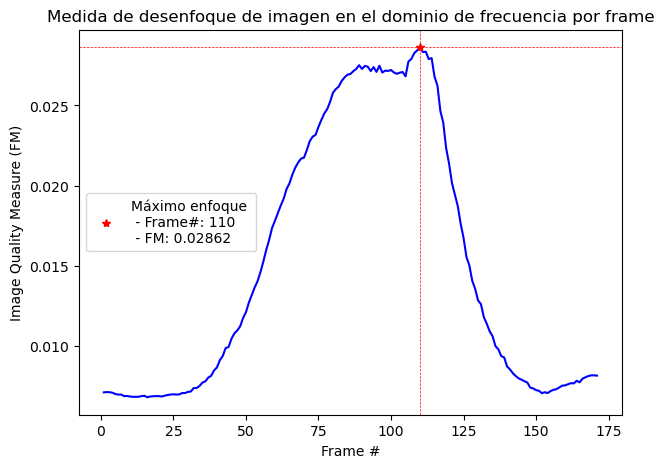

In [1818]:
xMax, yMax = showGraph(list(range(1, len(video_fm) + 1)), video_fm, 
          'Medida de desenfoque de imagen en el dominio de frecuencia por frame', 
          'Frame #', 
          'Image Quality Measure (FM)')


In [ ]:
# Video mostrando el frame de máximo enfoque
showVideo(video_path, title='Video - Enfoque - Frame Completo', props={'frames': True, 
                                                                       'max': xMax,
                                                                       'roi': False,
                                                                       'matrix': False})

In [1827]:
# Pico máximo de enfoque
max_value = max(video_fm)
# Umbral del 90% del valor máximo
threshold = 0.9 * max_value
# Indices donde las métricas son cercanas al máximo
max_frames = [i for i, val in enumerate(video_fm) if val >= threshold]  
x_from = max_frames[0] + 1
x_to = max_frames[-1] + 1
print(f"Máximo enfoque entre el frame {x_from} y el {x_to}.")


Máximo enfoque entre el frame 80 y el 116.


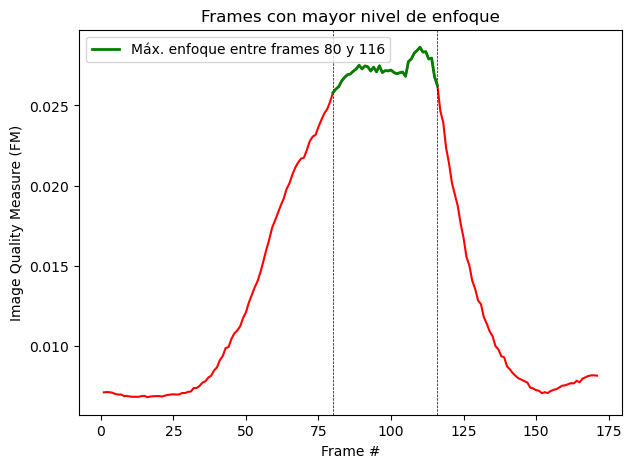

In [1829]:
# Gráfico mostrando la región de mayor enfoque
showGraphRange(list(range(1, len(video_fm) + 1)), video_fm, (x_from, x_to),
          'Frames con mayor nivel de enfoque', 
          'Frame #', 
          'Image Quality Measure (FM)')

In [ ]:
# Video mostrando el conjunto de frames de la región de mayor enfoque
showVideo(video_path, title='Video - Enfoque - Frame Completo', props={'frames': True, 
                                                                       'max': 0,
                                                                       'roi': False,
                                                                       'range': (x_from, x_to),
                                                                       'matrix': False})

### 2.1 Medición sobre una ROI ubicada en el centro del frame.

In [1835]:
percent = [5, 10, 20, 50, 100] # Porcentajes del área total
video_fm = {z: [] for z in percent}
roi_points = {z: [] for z in percent}

# Para los recortes establecidos
for p in percent:

    # Por cada frame del video:
    for frame in video_frames:
        # Convertir a escala de grises
        frame_g = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        # Obtener región de interés - dimensiones y posición
        roiShape, roiP = getDims(frame_g.shape, p, ['c', 'c'])
        frame_roi, p1, p2 = getROI(frame_g, roiShape, roiP)

        # Calcular métrica y almacenar para gráfico
        video_fm[p].append(getFM(frame_roi))
        # Guardar los puntos para dibujar rectángulo
        roi_points[p]=[p1, p2]

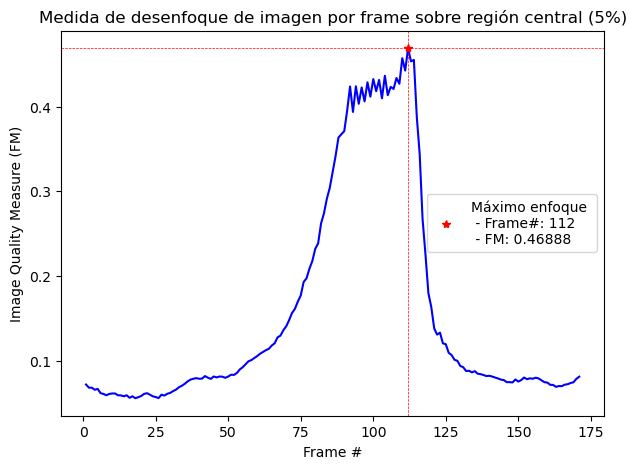

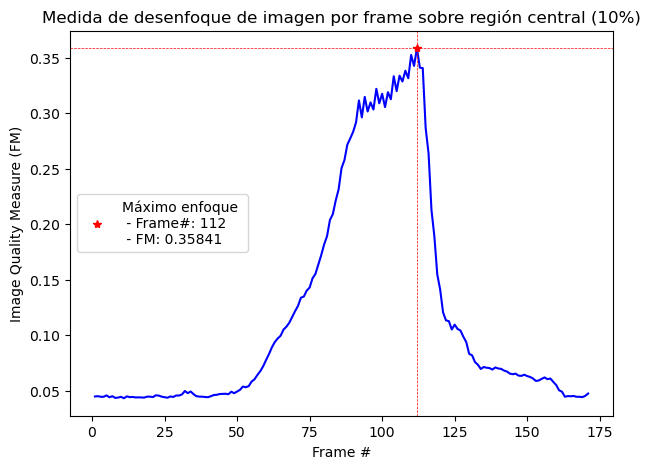

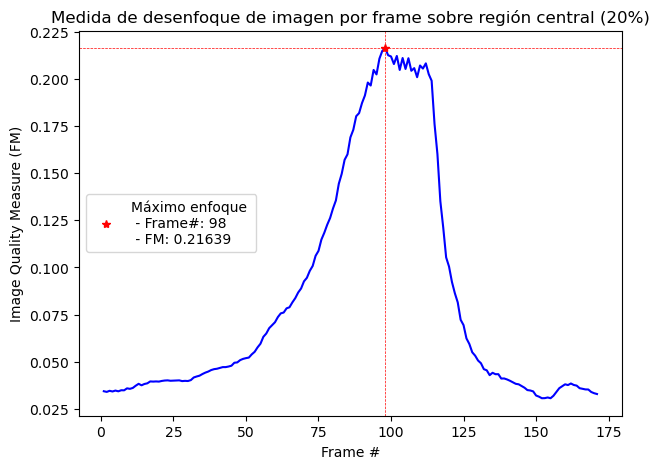

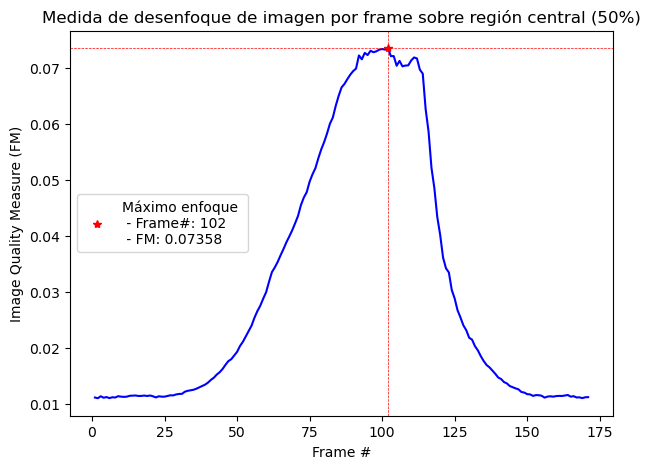

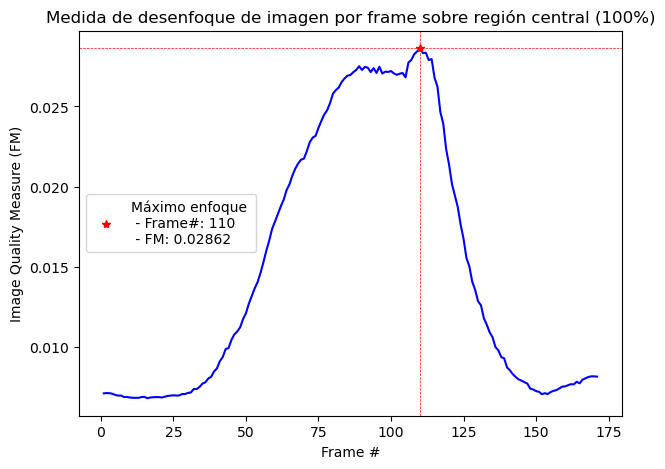

In [1836]:
for p in percent:
    showGraph(list(range(1, len(video_fm[p]) + 1)), video_fm[p], 
          f'Medida de desenfoque de imagen por frame sobre región central ({p}%)', 
          'Frame #', 
          'Image Quality Measure (FM)')


In [1839]:
# Tomamos los frames entre centrales para graficar juntas de forma comparativa las diferentes curvas.
_from = 75
_to = 125

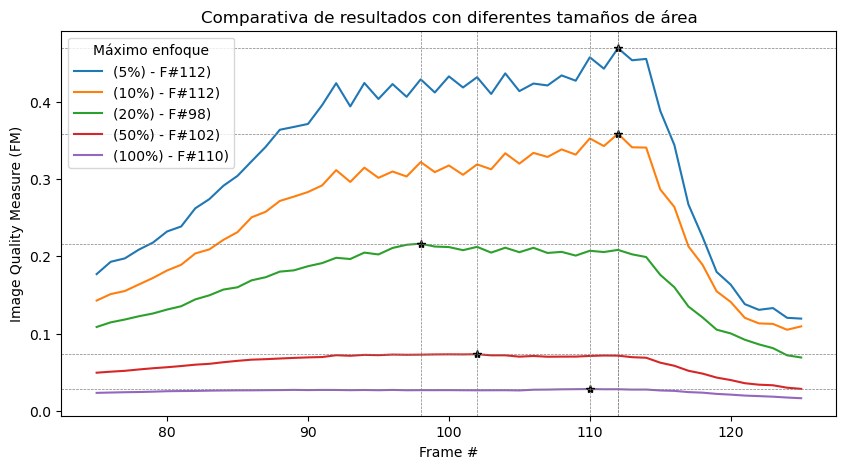

In [1841]:
plt.figure(figsize=(10, 5))

roi_max = {}

for p in percent:
    xMax = _from + np.argmax(video_fm[p][_from:_to+1]) + 1
    yMax = video_fm[p][xMax-1]
    roi_max[p] = xMax
    
    plt.plot(list(range(_from, _to+1)), video_fm[p][_from-1:_to], 
             label=f'({p}%) - F#{xMax})')

    plt.plot(xMax, yMax, 'k*')  
    plt.axhline(y=yMax, color='gray', linestyle='--', linewidth=0.5)  
    plt.axvline(x=xMax, color='gray', linestyle='--', linewidth=0.5)  


plt.title('Comparativa de resultados con diferentes tamaños de área')
plt.xlabel('Frame #')
plt.ylabel('Image Quality Measure (FM)')
plt.legend(title='Máximo enfoque')
plt.show()

In [ ]:
# Video destacando el punto máximo de enfoque con cada tamaño de ROI
for p in percent:

    showVideo(video_path, title=f'Video - Enfoque - ROI ({p}%)', 
          props={'frames': True, 'roi': roi_points[p], 'max': roi_max[p], 'matrix': False })


Máximo enfoque para 5% del área: entre el frame 92 y el 114.
Máximo enfoque para 10% del área: entre el frame 104 y el 114.
Máximo enfoque para 20% del área: entre el frame 92 y el 114.
Máximo enfoque para 50% del área: entre el frame 86 y el 114.
Máximo enfoque para 100% del área: entre el frame 80 y el 116.


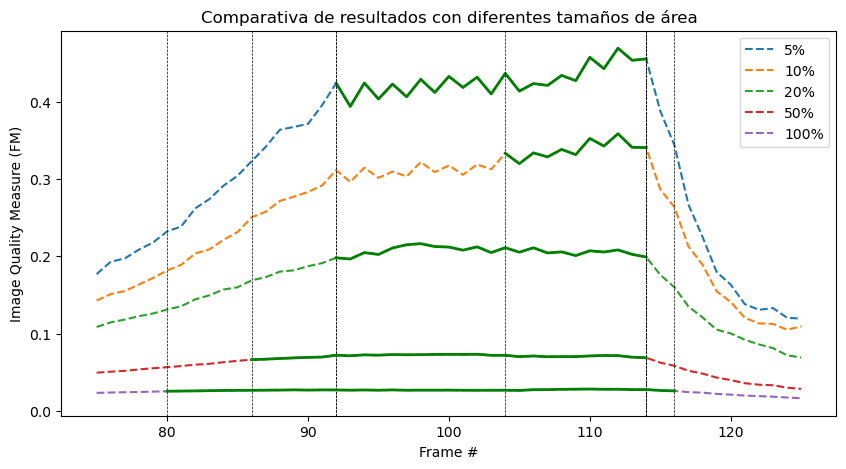

In [1846]:
# Intervalos de mayor enfoque

plt.figure(figsize=(10, 5))
_from = 75
_to = 125

for p in percent:
    # Pico máximo de enfoque
    max_value = max(video_fm[p])
    # Umbral del 90% del valor máximo
    threshold = 0.9 * max_value
    
    # Indices donde las métricas son cercanas al máximo
    max_frames = [i for i, val in enumerate(video_fm[p]) if val >= threshold]  
    x_from = max_frames[0] + 1
    x_to = max_frames[-1] + 1
    print(f"Máximo enfoque para {p}% del área: entre el frame {x_from} y el {x_to}.")

    x = list(range(_from, _to+1))
    y = video_fm[p][_from-1:_to]
    plt.plot(x, y, label=f'{p}%', linestyle='--')

    plt.axvline(x=x_from, color='black', linestyle='--', linewidth=0.5)  
    plt.axvline(x=x_to, color='black', linestyle='--', linewidth=0.5)  

    mp_x = np.array(x)
    mp_y = np.array(y)
    mask = (mp_x >= x_from) & (mp_x <= x_to)
    plt.plot(mp_x[mask], mp_y[mask], color='green', linewidth=2)


plt.title('Comparativa de resultados con diferentes tamaños de área')
plt.xlabel('Frame #')
plt.ylabel('Image Quality Measure (FM)')
plt.legend()
plt.show()


In [ ]:
# Video mostrando el conjunto de frames de la región con mayor enfoque según ROI
for p in percent:

    threshold = 0.9 * max(video_fm[p])
    max_frames = [i for i, val in enumerate(video_fm[p]) if val >= threshold]  
    x_from = max_frames[0] + 1
    x_to = max_frames[-1] + 1

    showVideo(video_path, title=f'Video - Enfoque - ROI ({p}%)', 
          props={'frames': True, 'roi': roi_points[p], 'max': 0, 'range': (x_from, x_to), 'matrix': False })

### 1.3 Medición con matriz de enfoque

In [1851]:
# Diferentes configuraciones de matrices de enfoque
focusMxs = [
{
    'rect_WxH': (10, 15),   # Dimensiones de los rectángulos equiespaciados (ancho x alto)
    'matrix_R-C': (5, 7),    # Dimensiones de la matriz (Filas - Columnas)
    'sep': 15               # Separación entre rectángulos de la matriz
},
{
    'rect_WxH': (50, 50), 
    'matrix_R-C': (3, 3),
    'sep': 10
},
{
    'rect_WxH': (20, 30), 
    'matrix_R-C': (5, 5),
    'sep': 20
},
{
    'rect_WxH': (30, 30), 
    'matrix_R-C': (7, 5),
    'sep': 10
},
{
    'rect_WxH': (15, 15), 
    'matrix_R-C': (9, 7),
    'sep': 10
}]


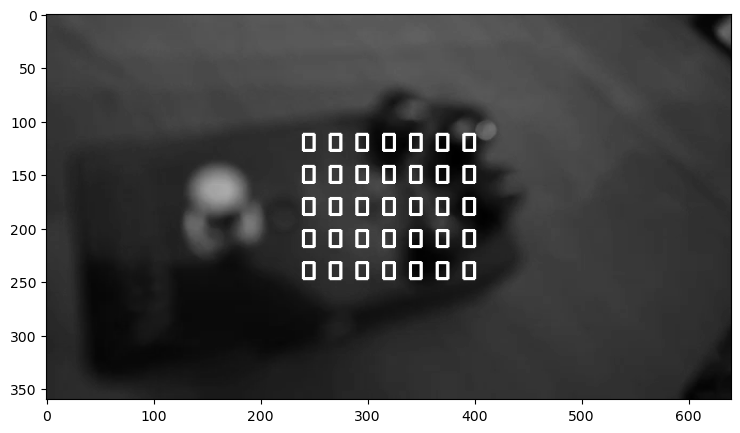

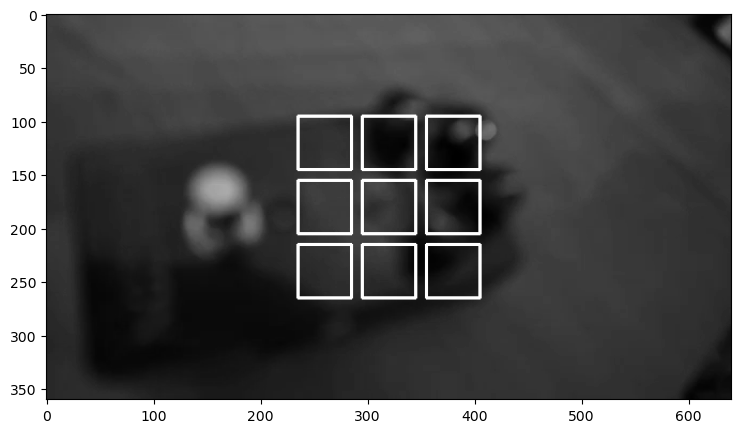

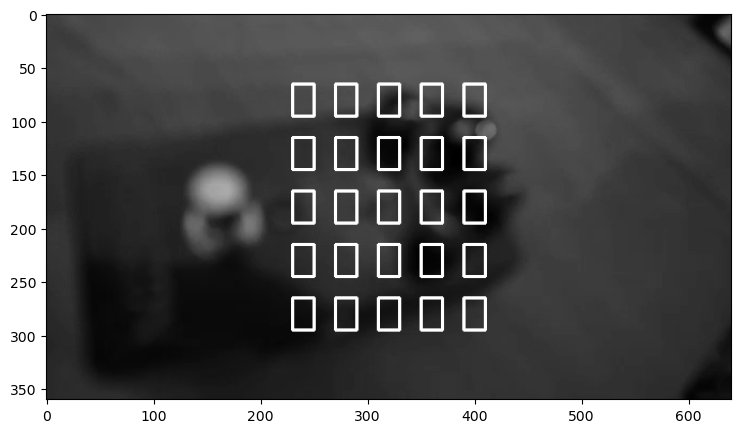

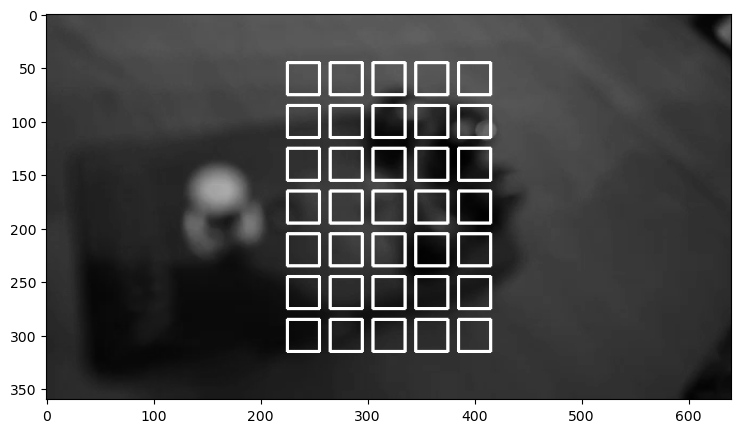

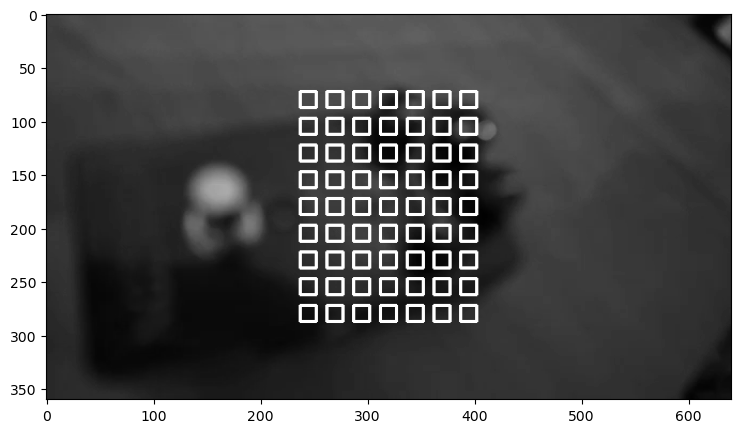

In [1853]:
# Ejemplo de visualización de las matrices de enfoque sobre el primer frame

for m in focusMxs:
    
    frame_g = cv.cvtColor(video_frames[0], cv.COLOR_BGR2GRAY)

    result, matrix = getFocusMatrix(frame_g.shape, m['rect_WxH'], m['matrix_R-C'], m['sep'])

    if result == "OK":
        frame_n = printFocusMatrix(frame_g, matrix)
        plt.figure(figsize=(10, 5))
        plt.imshow(frame_n, cmap='gray')
    else:
        print(result)


In [1855]:
video_fm = []

# Para los tamaños de matriz prestablecidos
for i, mx in enumerate(focusMxs):

    # video_fm contiene por cada matriz
    # promedio del frame y array con métricas parciales
    fmFrame = []
    
    _, fMx = getFocusMatrix(video_frames[0].shape, mx['rect_WxH'], mx['matrix_R-C'], mx['sep'])

    # Por cada frame del video:
    for frame in video_frames:
        # Convertir a escala de grises
        frame_g = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
        # Obtener las porciones de la imagen
        # Sub rectángulos de la matriz de enfoque
        s_fMx = getSubImgs(frame_g, fMx)

        fmAux = [] # Métricas parciales del frame
        
        for img in s_fMx:
            # Calcular la métrica por cada porción
            fmAux.append(getFM(img))

        # Promediar para encontrar una única métrica por frame
        fmFrame.append([np.mean(fmAux), fmAux])
        
    video_fm.append(fmFrame)


MATRIZ 1):

* Matriz de 5 filas y 7 columnas.

* Rectángulos de 10 de ancho y 15 de alto, equiespaciados por 15 pxs.



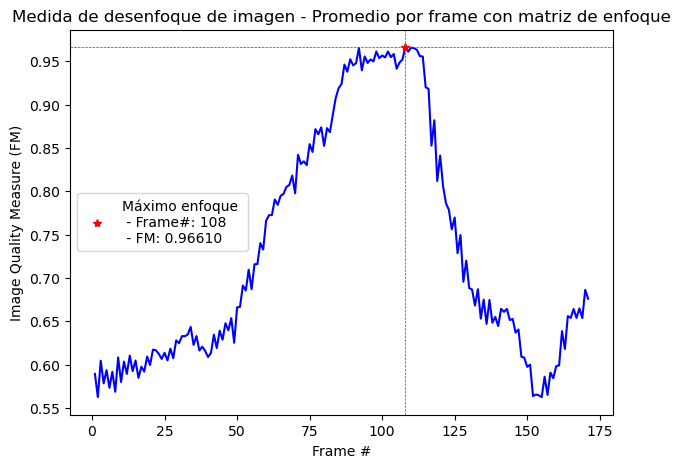


MATRIZ 2):

* Matriz de 3 filas y 3 columnas.

* Rectángulos de 50 de ancho y 50 de alto, equiespaciados por 10 pxs.



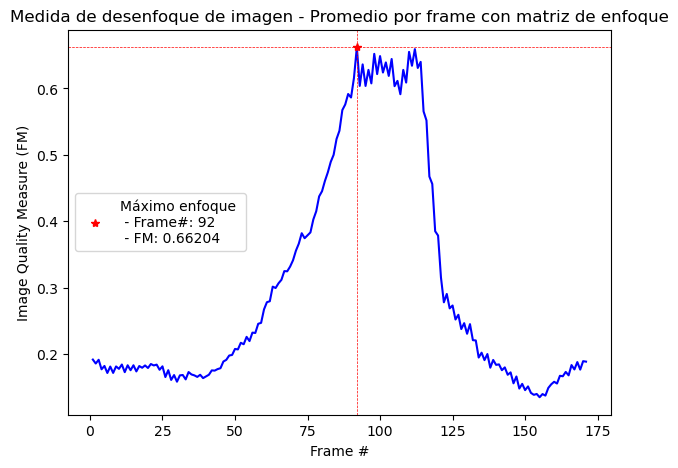


MATRIZ 3):

* Matriz de 5 filas y 5 columnas.

* Rectángulos de 20 de ancho y 30 de alto, equiespaciados por 20 pxs.



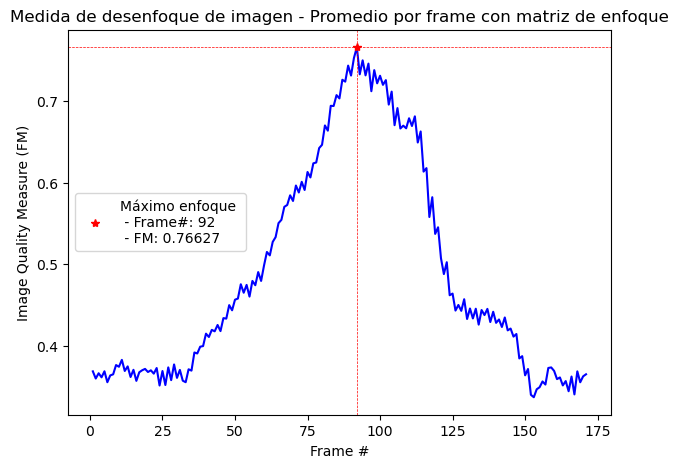


MATRIZ 4):

* Matriz de 7 filas y 5 columnas.

* Rectángulos de 30 de ancho y 30 de alto, equiespaciados por 10 pxs.



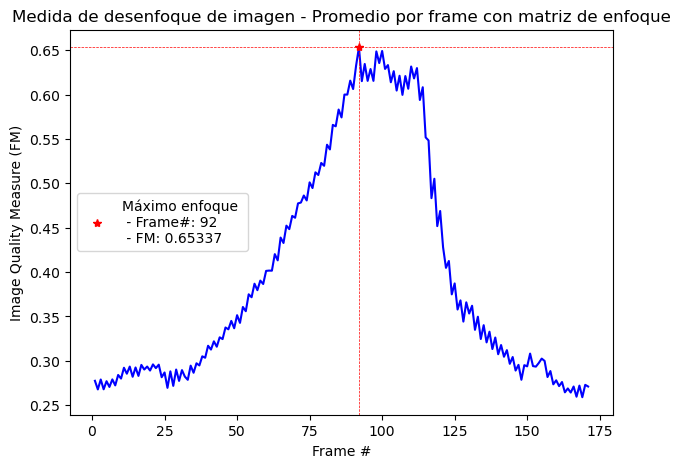


MATRIZ 5):

* Matriz de 9 filas y 7 columnas.

* Rectángulos de 15 de ancho y 15 de alto, equiespaciados por 10 pxs.



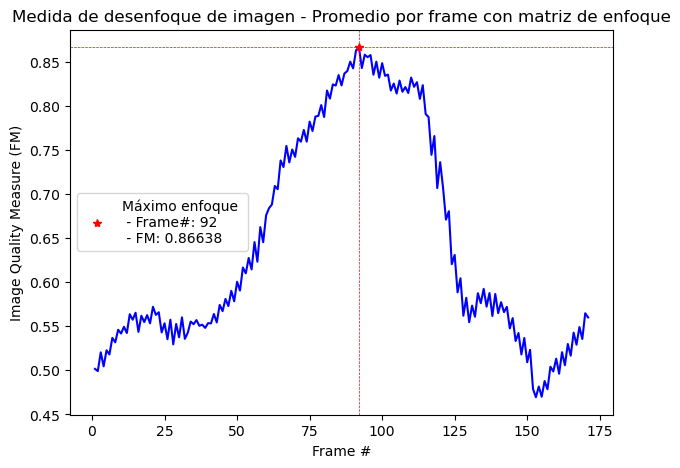

In [1857]:
for i, mx in enumerate(focusMxs):

    
    print()
    print(f"\033[1mMATRIZ {i+1}):\033[0m\n")
    print(f"\033[1m* Matriz de {mx['matrix_R-C'][0]} filas y {mx['matrix_R-C'][1]} columnas.\033[0m\n")
    print(f"\033[1m* Rectángulos de {mx['rect_WxH'][0]} de ancho y {mx['rect_WxH'][1]} de alto, equiespaciados por {mx['sep']} pxs.\033[0m\n")

    data = video_fm[i]

    x = list(range(1, len(data) + 1))
    y =  [row[0] for row in data]
    
    showGraph(x, y, f'Medida de desenfoque de imagen - Promedio por frame con matriz de enfoque', 
          'Frame #', 
          'Image Quality Measure (FM)')


In [1859]:
# Tomamos los frames centrales para graficar juntas de forma comparativa las diferentes curvas.
_from = 75
_to = 125


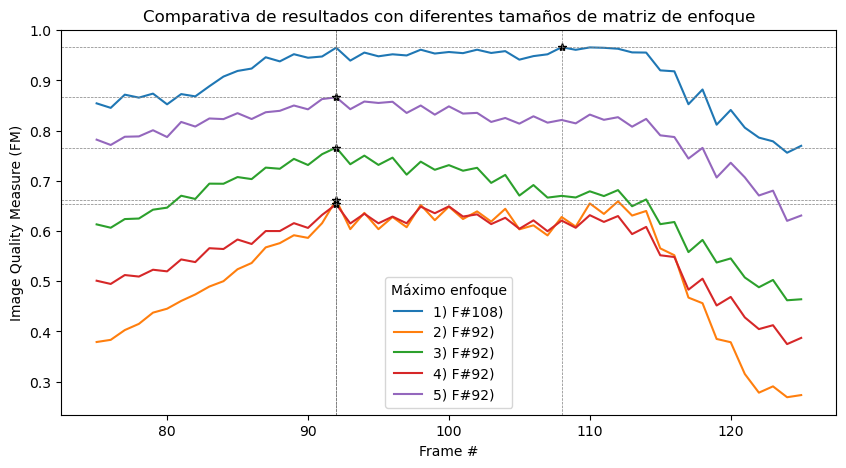

In [1861]:
plt.figure(figsize=(10, 5))

for i, mx in enumerate(focusMxs):

    data = video_fm[i]
    y =  [row[0] for row in data]

    xMax = _from + np.argmax(y[_from:_to+1]) + 1
    yMax = y[xMax-1]
    
    plt.plot(list(range(_from, _to+1)), y[_from-1:_to], label=f'{i+1}) F#{xMax})')

    plt.plot(xMax, yMax, 'k*')  
    plt.axhline(y=yMax, color='gray', linestyle='--', linewidth=0.5)  
    plt.axvline(x=xMax, color='gray', linestyle='--', linewidth=0.5)  


plt.title('Comparativa de resultados con diferentes tamaños de matriz de enfoque')
plt.xlabel('Frame #')
plt.ylabel('Image Quality Measure (FM)')
plt.legend(title='Máximo enfoque')
plt.show()




In [ ]:
# Video indicando el frame de máximo enfoque para las diferentes configuraciones de matriz
for i, mx in enumerate(focusMxs):

    data = video_fm[i]
    proms =  [row[0] for row in data]

    xMax = np.argmax(proms) + 1
    yMax = proms[xMax-1]
    
    showVideo(video_path, title=f'Video - Matriz de Enfoque ({i+1})', 
              props={'frames': True, 'roi': False, 'max': xMax , 'matrix': mx})

Máximo enfoque para la matriz 1: entre el frame 77 y el 118.
Máximo enfoque para la matriz 2: entre el frame 91 y el 114.
Máximo enfoque para la matriz 3: entre el frame 83 y el 106.
Máximo enfoque para la matriz 4: entre el frame 87 y el 114.
Máximo enfoque para la matriz 5: entre el frame 75 y el 116.


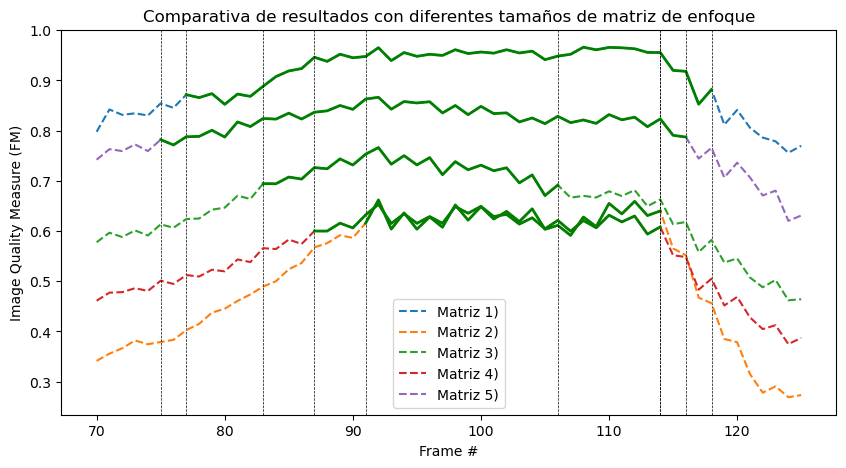

In [1865]:
# Intervalos de mayor enfoque
plt.figure(figsize=(10, 5))
_from = 70
_to = 125

for i, mx in enumerate(focusMxs):

    data = video_fm[i]
    y =  [row[0] for row in data]

    xMax = _from + np.argmax(y[_from:_to+1]) + 1
    yMax = y[xMax-1]
    # Umbral del 90% del valor máximo
    threshold = 0.9 * yMax

    # Indices donde las métricas son cercanas al máximo
    max_frames = [i for i, val in enumerate(y) if val >= threshold]  
    x_from = max_frames[0] + 1
    x_to = max_frames[-1] + 1
    print(f"Máximo enfoque para la matriz {i+1}: entre el frame {x_from} y el {x_to}.")

    x = list(range(_from, _to+1))
    y = y[_from-1:_to]
    plt.plot(x, y, label=f'Matriz {i+1})', linestyle='--')

    plt.axvline(x=x_from, color='black', linestyle='--', linewidth=0.5)  
    plt.axvline(x=x_to, color='black', linestyle='--', linewidth=0.5)  

    mp_x = np.array(x)
    mp_y = np.array(y)
    mask = (mp_x >= x_from) & (mp_x <= x_to)
    plt.plot(mp_x[mask], mp_y[mask], color='green', linewidth=2)


plt.title('Comparativa de resultados con diferentes tamaños de matriz de enfoque')
plt.xlabel('Frame #')
plt.ylabel('Image Quality Measure (FM)')
plt.legend()
plt.show()



In [ ]:
# Video señalando los frames de la región de mayor enfoque por matriz
for i, mx in enumerate(focusMxs):

    data = video_fm[i]
    proms =  [row[0] for row in data]

    xMax = np.argmax(proms) + 1
    yMax = proms[xMax-1]
    # Umbral del 90% del valor máximo
    threshold = 0.9 * yMax

    # Indices donde las métricas son cercanas al máximo
    max_frames = [i for i, val in enumerate(proms) if val >= threshold]  
    x_from = max_frames[0] + 1
    x_to = max_frames[-1] + 1

    showVideo(video_path, title=f'Video - Matriz de Enfoque ({i+1})', 
              props={'frames': True, 'roi': False, 'max': 0 , 'range': (x_from, x_to), 'matrix': mx})

## 2.

Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: ["Analysis of focus measure operators in shapefrom focus"](./papers/AnalysisOfFocusMeasureOperators.pdf).
El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera
automática.

In [1874]:
def showVideoPoints(path, title, props):
    """
    Pinta sobre el video los puntos indicados
    """
    try:    
        video_capture = cv.VideoCapture(path)
        
        if not video_capture.isOpened():
            print("Error al abrir el archivo de video")
        else:
            # tasa de cuadros (frame rate) del video
            fps = int(video_capture.get(cv.CAP_PROP_FPS))
            delay = int(1000/ fps)
            
            i=0
            while True:
                ret, frame = video_capture.read()
                if not ret:
                    break
                i = i + 1

                # Pasar la imagen a escala de grises
                new_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

                # tomar la medida de enfoque
                if props['measure']=='HelmliScherer':
                   _, result = getHelmliSchererFocusMeasure(new_frame)
                elif props['measure']=='Tenengrad':
                    result = getTenengradFocusMeasure(new_frame)
                else:
                    # Imprime frame original
                    new_frame = frame

                # Obtener los puntos de máximo enfoque según umbral
                max_points = getMaxFocusPoints(result, props['thres'])
                new_frame = printFrameNum(frame, i, (255, 0, 0), 0.5)
                for point in max_points:
                    # Dibujar círculo verde
                    cv.circle(new_frame, (point[1], point[0]), 5, (0, 255, 0), 2)  

                cv.imshow(title, new_frame)
                
                # Salir del loop si se presiona la tecla 'q'
                if cv.waitKey(delay) & 0xFF == ord('q'):
                    break
    finally:    
        # Liberar recursos
        video_capture.release()
        cv.destroyAllWindows()

def getMaxFocusPoints(res, thres):
    """
    Detecta los puntos con alta medida de enfoque
    """
    return np.argwhere(res > thres)


### 2.a

In [1877]:
def getHelmliSchererFocusMeasure(image):
    """
    Calcula la medida de enfoque de Helmli y Scherer usando el operador Laplaciano.
    Inputs: Imagen en escala de grises
    """
    # Aplicar el operador Laplaciano
    laplacian = cv.Laplacian(image, cv.CV_64F)

    # Normalizar el laplaciano para facilitar la visualización
    laplacian_n = cv.normalize(laplacian, None, 0, 255, cv.NORM_MINMAX)
    laplacian_n = np.uint8(laplacian_n)

    return laplacian, laplacian_n


In [ ]:
# Muestra el video marcando los puntos de máximo enfoque
showVideoPoints(video_path, title='Puntos de enfoque (Medida de Helmli & Scherer)', 
                props={'measure': 'HelmliScherer', 'thres': 250})

### 2.b

In [1882]:
def getTenengradFocusMeasure(image):
    """
    Calcula la medida de enfoque de Tenengrad usando el gradiente de la imagen.
    Inputs: imagen en escala de grises
    """

    # Calcular los gradientes en x e y usando el operador de Sobel
    grad_x = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=3)
    grad_y = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=3)

    # Devuelve la medida de Tenengrad como la suma de los cuadrados de los gradientes
    return np.sqrt(grad_x**2 + grad_y**2)


In [ ]:
# Muestra el video marcando los puntos de máximo enfoque
showVideoPoints(video_path, title='Puntos de enfoque (Tenengrad)', 
                props={'measure': 'Tenengrad', 'thres': 350})

## Adicional

Aplicar unsharp masking para expandir la zona de enfoque y devolver.

In [1888]:
def focusVideo(path, title, props):
    """
    Muestra el video enfocado junto con el original
    Devuelve las métricas de ambos por frame para comparación de resultados.
    * props
    recibe los números de frame sobre los que aplicar unsharped masking
    y las propiedades para el algoritmo en cada caso
    """

    fm = []
    
    try:    
        video_capture = cv.VideoCapture(path)
        
        if not video_capture.isOpened():
            print("Error al abrir el archivo de video")
        else:
            # tasa de cuadros (frame rate) del video
            fps = int(video_capture.get(cv.CAP_PROP_FPS))
            delay = int(1000 / fps)
            
            i=0

            while True:
                ret, frame = video_capture.read()
                if not ret:
                    break

                i = i + 1

                # Imprime frame original sin alterar por default
                new_frame = frame

                for f, p in props:
                    # f frames - p propiedades a aplicar
                    if i in f:
                        # Enfoca el frame
                        new_frame = unsharp_masking(frame, p)


                frame_g = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
                new_frame_g = cv.cvtColor(new_frame, cv.COLOR_BGR2GRAY)
                
                frame_combined = np.hstack((frame, new_frame))

                fm.append([getFM(frame_g), getFM(new_frame_g)])
        
                cv.imshow(title, frame_combined)
                
                # Salir del loop si se presiona la tecla 'q'
                if cv.waitKey(delay) & 0xFF == ord('q'):
                    break
    
    finally:    
        # Liberar recursos
        video_capture.release()
        cv.destroyAllWindows()

    return fm

In [1890]:
def unsharp_masking(image, props):
    """
    Aplica unsharp masking a la imagen
    Devuelve imagen ajustada
    """
    
    gauss = cv.GaussianBlur(image, props['ksize'], props['sigma'])
    new_img = cv.addWeighted(image, props['k'] + 1, gauss, -props['k'], 0)
    
    return new_img


In [1892]:
# Dividimos el video en regiones de mayor y menor enfoque
# para poder aplicar unsharped masking sobre ciertos frames con diferentes propiedades

video_fm = []
for frame in video_frames:
    frame_g = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # Calcular métrica y almacenar para gráfico
    video_fm.append(getFM(frame_g))

_, max_val, _, max_loc = cv.minMaxLoc(np.array(video_fm))

thresholds = [0.90, 0.70, 0.50, 0.40, 0.35, 0.25]

target_frames = {}
target_points = {}
for k in range (0, 7):
    
    t1 = thresholds[k] if k < 6 else 0
    t2 = thresholds[k-1] if k > 0 else 1
    target_frames[k] = [i for i, val in enumerate(video_fm) if val >= t1*max_val and val < t2*max_val]
    _, _, (_, x1), (_, x2) = cv.minMaxLoc(np.array(target_frames[k]))
    target_points[k] = [target_frames[k][x1], target_frames[k][x2]]



In [ ]:
# Video original vs. enfocado
fm = focusVideo(video_path, "Video procesado con 'Unsharp Masking'", 
            [
            [target_frames[1], {'ksize': (3, 3), 'sigma': 1.0, 'k': 0.5}],
            [target_frames[2], {'ksize': (3, 3), 'sigma': 1.0, 'k': 3}],
            [target_frames[3], {'ksize': (5, 5), 'sigma': 1.0, 'k': 5}],
            [target_frames[4], {'ksize': (5, 5), 'sigma': 1.0, 'k': 10}],
            [target_frames[5], {'ksize': (5, 5), 'sigma': 1.0, 'k': 10}],
            [target_frames[6], {'ksize': (7, 7), 'sigma': 1.0, 'k': 10}]
            ])


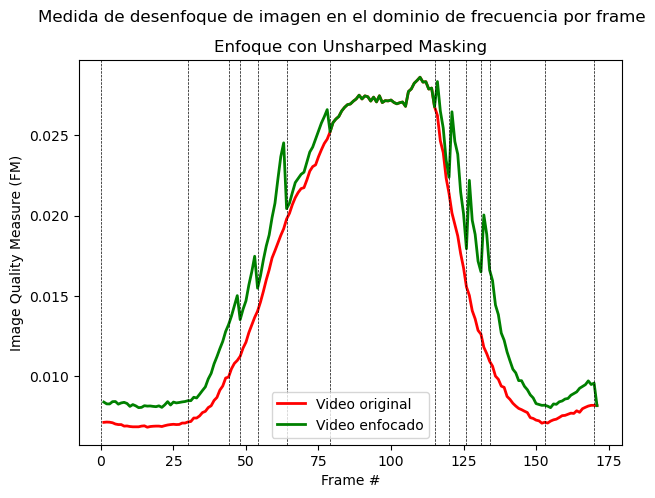

In [1898]:
# Comparativa de métricas de enfoque entre el video original
# y el procesado con Unsharped Masking

np_fm = np.array(fm)

fm_orig = np_fm[:, 0] # fm sin UM
fm_new = np_fm[:, 1] # fm con UM

x = [i for i in range(1, len(fm) + 1)]
y1 = fm_orig
y2 = fm_new
   
plt.figure(figsize=(7, 5))
plt.plot(x, y1, color='red', linewidth=2, label=f'Video original')
plt.plot(x, y2, color='green', linewidth=2, label=f'Video enfocado')

for (x1, x2) in target_points.values():
    plt.axvline(x=x1, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(x=x2, color='black', linewidth=0.5, linestyle='--')

plt.suptitle('Medida de desenfoque de imagen en el dominio de frecuencia por frame')
plt.title('Enfoque con Unsharped Masking')
plt.xlabel('Frame #')
plt.ylabel('Image Quality Measure (FM)')

plt.legend(loc='best')
plt.grid(False)
plt.show()

## Bibliografía

* Image Sharpness Measure for Blurred Images in Frequency Domain (Kanjar De and V. Masilamani)  

* Analysis of focus measure operators for shape-from-focus (Said Pertuz - Domenec Puig - Miguel Angel Garcia)  
